Notebook for testing density estimation.

# Libs

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from scipy.stats import t
from scipy.stats import norm


from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.neighbors import KernelDensity

from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.model_selection import ParameterGrid

import sys
sys.path.append("..")
from src.preprocessing import KernelDensityEstimation

# Data

In [2]:
# Dados
data_path = "../data/processed/"
returns_path = ''.join([data_path, 'ibovespa_treated.xlsx'])
df = pd.read_excel(returns_path, index_col="time")
df.head()

,2024-12-02,2024-12-03,2024-12-04,2024-12-05,2024-12-06,2024-12-09,2024-12-10,2024-12-11,2024-12-12,2024-12-13,...,2025-11-14,2025-11-17,2025-11-18,2025-11-19,2025-11-21,2025-11-24,2025-11-25,2025-11-26,2025-11-27,2025-11-28
time,,,,,,,,,,,,,,,,,,,,,
10:00:00,0.000011,-0.000372,-0.000035,0.007233,-0.001305,-0.000459,0.002388,0.002212,-0.008001,-0.000824,...,-0.000957,-0.002307,-0.003734,-0.005020,-0.001139,-0.000255,0.002339,0.004176,-0.000224,-0.000238
10:05:00,-0.002271,0.003372,0.001716,0.005538,0.000069,0.006429,0.002343,0.001918,-0.007582,-0.000413,...,-0.001522,0.000739,-0.000613,0.000306,-0.002021,-0.000810,0.001557,-0.001565,-0.000193,0.002906
10:10:00,-0.000582,0.002832,-0.000502,0.000739,0.000261,0.001891,0.000775,-0.001172,0.000216,-0.000432,...,0.000360,-0.000105,-0.000159,-0.000362,0.000092,0.001131,0.001170,0.000202,0.000556,0.000475
10:15:00,-0.001997,0.001091,0.000111,-0.000192,0.000407,-0.001392,-0.000477,-0.001526,0.000198,-0.001821,...,0.001121,-0.000284,0.003272,-0.001107,-0.001012,-0.000174,0.001002,0.001815,-0.000168,0.000973
10:20:00,-0.000037,-0.000505,-0.000327,-0.000580,-0.000436,-0.000405,0.001263,0.000676,-0.002667,0.001033,...,0.000449,0.000335,0.000853,0.000981,-0.000057,-0.000096,0.000832,0.001951,0.001060,-0.001004


In [3]:
import seaborn as sns
# plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

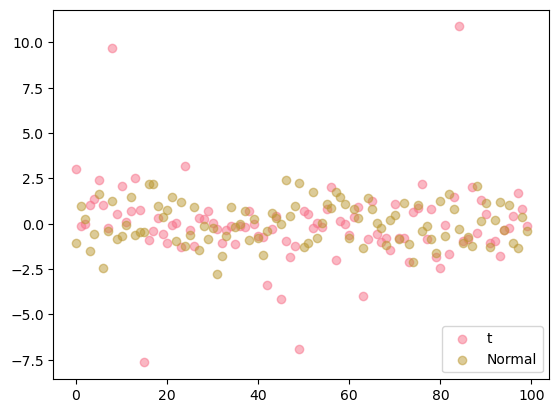

In [4]:
theoretical_deg_freedom = 3
n = 100

np.random.seed(123)
# data = t.rvs(df=theoretical_deg_freedom, size=n)

normal_samples = np.random.normal(loc=0, scale=1, size=n)
t_samples = np.random.standard_t(df=theoretical_deg_freedom, size=n)

plt.figure()
plt.scatter(np.arange(n),t_samples, label="t", alpha=.5)
plt.scatter(np.arange(n),normal_samples, label="Normal", alpha=.5)

plt.legend()

plt.show()

# t-kernel

In [7]:
n = len(t_samples)
h = 1.06 * np.std(t_samples, ddof=1) * n ** (-1/5)

In [8]:
grid = np.linspace(
    t_samples.min() - 3 * h,
    t_samples.max() + 3 * h,
    400
)

In [ ]:
t2_kde = KernelDensityEstimation(kernel="t_student", bandwidth=h, df=2)
t2_kde = t2_kde.fit_transform(t_samples)

t4_kde = KernelDensityEstimation(kernel="t_student", bandwidth=h, df=4)
t4_kde = t4_kde.fit_transform(t_samples)

n_kde0 = KernelDensityEstimation(kernel="gaussian", bandwidth=h)
n_kde = n_kde0.fit_transform(t_samples)

new_grid = n_kde0.grid

In [31]:
fig = go.Figure()

# Gaussian KDE
fig.add_trace(
    go.Scatter(
        x=new_grid,
        y=n_kde,
        mode="lines",
        name="Gaussian KDE",
        line=dict(color="black")
    )
)

# t-kernel KDE df = 4
fig.add_trace(
    go.Scatter(
        x=new_grid,
        y=t4_kde,
        mode="lines",
        name="t-kernel KDE df = 4",
        line=dict(color="green")
    )
)

# t-kernel KDE df = 2
fig.add_trace(
    go.Scatter(
        x=new_grid,
        y=t2_kde,
        mode="lines",
        name="t-kernel KDE df = 2",
        line=dict(color="red")
    )
)

# Histogram
fig.add_trace(
    go.Histogram(
        x=t_samples,
        nbinsx=20,
        histnorm="probability density",
        marker=dict(color="gray"),
        opacity=0.2,
        name="Histogram"
    )
)

fig.update_layout(
    title="Gaussian vs Student-t KDE",
    width=800,
    height=400,
    template="simple_white",
    xaxis_title="x",
    yaxis_title="Density",
    legend=dict(x=0.02, y=0.98),
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.2)")
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.2)")

fig.update_layout(
    legend=dict(
        x=1.02,
        y=1,
        xanchor="left",
        yanchor="top"
    ),
    margin=dict(r=160)  # make room for the legend
)

fig.show()

## Teste de classe

In [227]:
theoretical_deg_freedom = 3
n = 100

np.random.seed(123)
data = t.rvs(df=theoretical_deg_freedom, size=n)

normal_samples = np.random.normal(loc=0, scale=1, size=n)
t_samples = np.random.standard_t(df=theoretical_deg_freedom, size=n)

In [5]:
gaussian_kde = KernelDensityEstimation(kernel="gaussian", bandwidth='silverman')
gaussian_density = gaussian_kde.fit_transform(t_samples)

# t_kde = KernelDensityEstimation(kernel="t_student", bandwidth=h, df = 3)
# t_density = t_kde.fit_transform(t_samples)

t2_kde = KernelDensityEstimation(kernel="t_student", bandwidth='silverman', df = 3)
t2_density = t2_kde.fit_transform(t_samples)

t3_kde = KernelDensityEstimation(kernel="t_student", bandwidth='scott', df = 3)
t3_density = t3_kde.fit_transform(t_samples)

t4_kde = KernelDensityEstimation(kernel="t_student", bandwidth='silverman', df = 3, adaptive=True)
t4_density = t4_kde.fit_transform(t_samples)

In [6]:
fig = go.Figure()

# Gaussian KDE
fig.add_trace(
    go.Scatter(
        x=gaussian_kde.grid,
        y=gaussian_density,
        mode="lines",
        name="Gaussian KDE | silverman",
        line=dict(color="black")
    )
)

# t-kernel KDE df = 4
fig.add_trace(
    go.Scatter(
        x=t2_kde.grid,
        y=t2_density,
        mode="lines",
        name="t-kernel KDE | df = 3 | silverman",
        line=dict(color="green")
    )
)

# t-kernel KDE df = 2
fig.add_trace(
    go.Scatter(
        x=t3_kde.grid,
        y=t3_density,
        mode="lines",
        name="t-kernel KDE | df = 3 | scott",
        line=dict(color="red")
    )
)

fig.add_trace(
    go.Scatter(
        x=t4_kde.grid,
        y=t4_density,
        mode="lines",
        name="t-kernel KDE | df = 3 | silverman + adaptive",
        line=dict(color="orange")
    )
)

# Histogram
fig.add_trace(
    go.Histogram(
        x=t_samples,
        nbinsx=50,
        histnorm="probability density",
        marker=dict(color="gray"),
        opacity=0.2,
        name="Histogram"
    )
)


fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.2)")
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.2)")

fig.update_layout(
    legend=dict(
        x=1.02,
        y=1,
        xanchor="left",
        yanchor="top"
    ),
    margin=dict(r=160)  # make room for the legend
)

fig.show()

## h: cross validation

In [7]:
gaussian_kde = KernelDensityEstimation(kernel="gaussian", bandwidth='silverman')
gaussian_density = gaussian_kde.fit_transform(t_samples)

# t_kde = KernelDensityEstimation(kernel="t_student", bandwidth=h, df = 3)
# t_density = t_kde.fit_transform(t_samples)

t2_kde = KernelDensityEstimation(kernel="t_student", bandwidth='silverman', df = 3)
t2_density = t2_kde.fit_transform(t_samples)

t3_kde = KernelDensityEstimation(kernel="t_student", bandwidth='scott', df = 3)
t3_density = t3_kde.fit_transform(t_samples)

t4_kde = KernelDensityEstimation(kernel="t_student", bandwidth='silverman', df = 3)
t4_density = t4_kde.fit_transform(t_samples, adaptive=True)

t5_kde = KernelDensityEstimation(kernel="t_student", df = 3, bandwidth='cv')
t5_density = t5_kde.fit_transform(t_samples, adaptive=True)

In [8]:
fig = go.Figure()

# Gaussian KDE
fig.add_trace(
    go.Scatter(
        x=gaussian_kde.grid,
        y=gaussian_density,
        mode="lines",
        name="Gaussian KDE | silverman",
        line=dict(color="black")
    )
)

# t-kernel KDE df = 4
fig.add_trace(
    go.Scatter(
        x=t2_kde.grid,
        y=t2_density,
        mode="lines",
        name="t-kernel KDE | df = 3 | silverman",
        line=dict(color="green")
    )
)

# t-kernel KDE df = 2
fig.add_trace(
    go.Scatter(
        x=t3_kde.grid,
        y=t3_density,
        mode="lines",
        name="t-kernel KDE | df = 3 | scott",
        line=dict(color="red")
    )
)

fig.add_trace(
    go.Scatter(
        x=t4_kde.grid,
        y=t4_density,
        mode="lines",
        name="t-kernel KDE | df = 3 | silverman + adaptive",
        line=dict(color="orange")
    )
)

fig.add_trace(
    go.Scatter(
        x=t5_kde.grid,
        y=t5_density,
        mode="lines",
        name="t-kernel KDE | df = 3 | h cross-validated",
        line=dict(color="purple")
    )
)

# Histogram
fig.add_trace(
    go.Histogram(
        x=t_samples,
        nbinsx=50,
        histnorm="probability density",
        marker=dict(color="gray"),
        opacity=0.2,
        name="Histogram"
    )
)


fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.2)")
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor="rgba(0,0,0,0.2)")

fig.update_layout(
    legend=dict(
        x=1.02,
        y=1,
        xanchor="left",
        yanchor="top"
    ),
    margin=dict(r=160)  # make room for the legend
)

fig.show()

In [17]:
def fit_kde_model(samples, params):
    """
    Fit a KDE model given a parameter dictionary.
    """
    kde = KernelDensityEstimation(
        kernel=params["kernel"],
        bandwidth=params["bandwidth"],
        adaptive=params.get("adaptive", False),
        df=params.get("df", None),
    )

    grid = kde.grid
    density = kde.fit_transform(samples)
    
    return kde, grid, density

In [18]:
param_grid = [
    {'kernel': ['gaussian', 'epanechnikov'],
        'bandwidth': ['silverman', 'scott', 'cv'],
        'adaptive': [True, False]}, 
    {'kernel': ['t_student'], 
        'df': [2, 5],
        'bandwidth': ['silverman', 'scott', 'cv'],
        'adaptive': [True, False]}]
list(ParameterGrid(param_grid))

[{'adaptive': True, 'bandwidth': 'silverman', 'kernel': 'gaussian'},
 {'adaptive': True, 'bandwidth': 'silverman', 'kernel': 'epanechnikov'},
 {'adaptive': True, 'bandwidth': 'scott', 'kernel': 'gaussian'},
 {'adaptive': True, 'bandwidth': 'scott', 'kernel': 'epanechnikov'},
 {'adaptive': True, 'bandwidth': 'cv', 'kernel': 'gaussian'},
 {'adaptive': True, 'bandwidth': 'cv', 'kernel': 'epanechnikov'},
 {'adaptive': False, 'bandwidth': 'silverman', 'kernel': 'gaussian'},
 {'adaptive': False, 'bandwidth': 'silverman', 'kernel': 'epanechnikov'},
 {'adaptive': False, 'bandwidth': 'scott', 'kernel': 'gaussian'},
 {'adaptive': False, 'bandwidth': 'scott', 'kernel': 'epanechnikov'},
 {'adaptive': False, 'bandwidth': 'cv', 'kernel': 'gaussian'},
 {'adaptive': False, 'bandwidth': 'cv', 'kernel': 'epanechnikov'},
 {'adaptive': True, 'bandwidth': 'silverman', 'df': 2, 'kernel': 't_student'},
 {'adaptive': True, 'bandwidth': 'silverman', 'df': 5, 'kernel': 't_student'},
 {'adaptive': True, 'bandwid

In [19]:
results = []

for params in ParameterGrid(param_grid):
    kde, grid, density = fit_kde_model(t_samples, params)

    results.append({
        "params": params,
        "grid": grid,
        "density": density,
        "kde": kde,
    })

# TODO: AJUSTAR GRID

In [36]:
rows = []

for res in results:
    params = res["params"]
    # grid = res["grid"]
    density = res["density"]
    grid = np.linspace(t_samples.min(), t_samples.max(), 256)

    for x, f in zip(grid, density):
        rows.append({
            "x": x,
            "density": f,
            **params
        })

df = pd.DataFrame(rows)
df

,x,density,adaptive,bandwidth,kernel,df
0,-7.653227,0.004794,True,silverman,gaussian,NaN
1,-7.580553,0.004854,True,silverman,gaussian,NaN
2,-7.507880,0.004908,True,silverman,gaussian,NaN
3,-7.435206,0.004957,True,silverman,gaussian,NaN
4,-7.362533,0.005000,True,silverman,gaussian,NaN
...,...,...,...,...,...,...
6139,10.587836,0.007129,False,cv,t_student,5.0
6140,10.660510,0.007085,False,cv,t_student,5.0
6141,10.733184,0.007011,False,cv,t_student,5.0
6142,10.805857,0.006897,False,cv,t_student,5.0


In [37]:
df["model"] = (
    df["kernel"]
    + ", h=" + df["bandwidth"].astype(str)
    + ", adaptive=" + df["adaptive"].astype(str)
    + df["df"].fillna("").apply(lambda x: f", df={x}" if not pd.isna(x) else "")
)
df["df_label"] = df["df"].fillna("NA")
df

,x,density,adaptive,bandwidth,kernel,df,model,df_label
0,-7.653227,0.004794,True,silverman,gaussian,NaN,"gaussian, h=silverman, adaptive=True, df=",NA
1,-7.580553,0.004854,True,silverman,gaussian,NaN,"gaussian, h=silverman, adaptive=True, df=",NA
2,-7.507880,0.004908,True,silverman,gaussian,NaN,"gaussian, h=silverman, adaptive=True, df=",NA
3,-7.435206,0.004957,True,silverman,gaussian,NaN,"gaussian, h=silverman, adaptive=True, df=",NA
4,-7.362533,0.005000,True,silverman,gaussian,NaN,"gaussian, h=silverman, adaptive=True, df=",NA
...,...,...,...,...,...,...,...,...
6139,10.587836,0.007129,False,cv,t_student,5.0,"t_student, h=cv, adaptive=False, df=5.0",5.0
6140,10.660510,0.007085,False,cv,t_student,5.0,"t_student, h=cv, adaptive=False, df=5.0",5.0
6141,10.733184,0.007011,False,cv,t_student,5.0,"t_student, h=cv, adaptive=False, df=5.0",5.0
6142,10.805857,0.006897,False,cv,t_student,5.0,"t_student, h=cv, adaptive=False, df=5.0",5.0


In [38]:
df.model.unique()

array(['gaussian, h=silverman, adaptive=True, df=',
       'epanechnikov, h=silverman, adaptive=True, df=',
       'gaussian, h=scott, adaptive=True, df=',
       'epanechnikov, h=scott, adaptive=True, df=',
       'gaussian, h=cv, adaptive=True, df=',
       'epanechnikov, h=cv, adaptive=True, df=',
       'gaussian, h=silverman, adaptive=False, df=',
       'epanechnikov, h=silverman, adaptive=False, df=',
       'gaussian, h=scott, adaptive=False, df=',
       'epanechnikov, h=scott, adaptive=False, df=',
       'gaussian, h=cv, adaptive=False, df=',
       'epanechnikov, h=cv, adaptive=False, df=',
       't_student, h=silverman, adaptive=True, df=2.0',
       't_student, h=silverman, adaptive=True, df=5.0',
       't_student, h=scott, adaptive=True, df=2.0',
       't_student, h=scott, adaptive=True, df=5.0',
       't_student, h=cv, adaptive=True, df=2.0',
       't_student, h=cv, adaptive=True, df=5.0',
       't_student, h=silverman, adaptive=False, df=2.0',
       't_student, 

In [39]:
fig = px.line(
    df,
    x="x",
    y="density",
    color="model"
)

fig.update_layout(
    title="Kernel Density Estimates",
    xaxis_title="x",
    yaxis_title="Density",
    legend=dict(x=1.02, y=1),
    margin=dict(r=200),
    template="simple_white"
)

fig.show()